# Trinomial Tree Option Pricer - Demo & Validation

This notebook demonstrates the core capabilities of the `trinomial_tree` library, focusing on performance, accuracy, and structural analysis of the pricing model.

It covers:
1.  **Basic Pricing**: Comparing Tree vs Black-Scholes.
2.  **Performance Benchmarking**: Parallelized analysis of Time and Space complexity ($O(N)$ vs $O(N^2)$).
3.  **Financial Consistency**: Validating Put-Call Parity.
4.  **Convergence Analysis**: Validating numerical stability as $N$ increases.
5.  **Sensitivity Analysis**: Computing Greeks (Delta, Gamma, Vega, Theta) via both tree-internal methods and empirical shocks.
6.  **Structural Analysis**: Inspecting Early Exercise Boundaries (American Options) and Terminal Distributions.

> **Note**: This demo is not exhaustive. It does not showcase all features implemented in the library, specifically:
> *   **Barrier Options**: The library supports Knock-In/Knock-Out barriers (Up/Down), verified in the test suite but not detailed here.
> *   **Discrete Dividends**: The model handles discrete cash dividends during the life of the option, but this demo uses a zero-dividend assumption.
> *   **Advanced Configuration**: Customizing tree stretch parameters ($\lambda$) or pruning thresholds via `PricingConfig`.
> *   **Tree Visualization**: The topology of the lattice is not plotted in this notebook.

In [1]:
import time
import tracemalloc
import concurrent.futures
import datetime as dt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from trinomial_tree.pricing import (
    MarketData,
    Option,
    Tree,
    BlackScholes,
    InductiveTree,
    Barrier,
    BarrierType,
    BarrierDirection,
)
from trinomial_tree.analysis import (
    Visualizer,
    EmpiricalGreeks,
)
from trinomial_tree.analysis.experiments import (
    ConvergenceExperiment,
    SpotSensitivityExperiment,
    VolatilitySensitivityExperiment,
    PutCallParityExperiment,
    ExerciseBoundaryExperiment,
    TerminalDistributionExperiment,
)

pd.options.display.float_format = "{:,.4f}".format


## 1. Basic Pricing Configuration

We define a standard market environment and a European Call option to establish a baseline.

In [2]:
# Market Configuration
today = dt.date(2023, 1, 1)
maturity = today + dt.timedelta(days = 10)

market_data = MarketData(
    spot_price=100.0,
    start_date=today,
    volatility=0.2,
    interest_rate=0.05,
    discount_rate=0.05,
    dividend_ex_date=today + dt.timedelta(days=1), # No dividends
    dividend_amount=0.0
)

# Option Configuration (European Call)
european_call = Option(
    maturity=maturity,
    strike_price=100.0,
    is_call=True,
    is_american=False,
    barrier=None,
    pricing_date=today,
    calendar_base_convention=365
)

print(f"Market Data: S0={market_data.spot_price}, Vol={market_data.volatility}, r={market_data.interest_rate}")
print(f"Option: K={european_call.strike_price}, T={(maturity-today).days/365:.2f} years")

Market Data: S0=100.0, Vol=0.2, r=0.05
Option: K=100.0, T=0.03 years


## 1.2 Basic Pricing Benchmark
We compare the basic implementation against the Black-Scholes analytical formula.

In [3]:
# 1. Black-Scholes Benchmark
bs_pricer = BlackScholes(market_data, european_call)
bs_price = bs_pricer.price()

# 2. Trinomial Tree Pricing (N=200)
tree_pricer = Tree(num_steps=1000, market_data=market_data, option=european_call)
tree_price = tree_pricer.price()

# 3. Inductive Tree Pricing (N=200) - Optimized O(N) space
inductive_tree_pricer = InductiveTree(num_steps=1000, market_data=market_data, option=european_call)
inductive_tree_price = inductive_tree_pricer.price()

print(f"Black-Scholes Price: {bs_price:.6f}")
print(f"Trinomial Tree Price: {tree_price:.6f}")
print(f"Error: {abs(tree_price - bs_price):.6e}")
print(f"Inductive Tree Price: {inductive_tree_price:.6f}")
print(f"Error: {abs(inductive_tree_price - bs_price):.6e}")

Black-Scholes Price: 1.389280
Trinomial Tree Price: 1.389315
Error: 3.581531e-05
Inductive Tree Price: 1.389315
Error: 3.562678e-05


## 2. Performance Benchmarking
We analyze the memory scaling of the Inductive Tree ($O(N)$) versus the Standard Tree ($O(N^2)$).

In [4]:
# Pricing time and memory usage comparison

tracemalloc.start()
start_time = time.time()
inductive_tree_price = inductive_tree_pricer.price()
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Inductive Tree Pricing Time: {end_time - start_time:.6f} seconds")
print(f"Inductive Tree Memory Usage: Current={current / 10**6:.6f}MB, Peak={peak / 10**6:.6f}MB")

tracemalloc.start()
start_time = time.time()
tree_price = tree_pricer.price()
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Trinomial Tree Pricing Time: {end_time - start_time:.6f} seconds")
print(f"Trinomial Tree Memory Usage: Current={current / 10**6:.6f}MB, Peak={peak / 10**6:.6f}MB")

Inductive Tree Pricing Time: 0.057086 seconds
Inductive Tree Memory Usage: Current=0.002310MB, Peak=0.116007MB
Trinomial Tree Pricing Time: 23.563853 seconds
Trinomial Tree Memory Usage: Current=64.254717MB, Peak=64.274975MB


Trinomial Tree Pricing Time: 23.563853 seconds
Trinomial Tree Memory Usage: Current=64.254717MB, Peak=64.274975MB
Running Memory Scaling Benchmark (Parallelized)...
  Finished Inductive Tree N=100 -> 0.01 MB
  Finished Inductive Tree N=500 -> 0.06 MB
  Finished Inductive Tree N=1000 -> 0.11 MB
  Finished Inductive Tree N=1500 -> 0.17 MB
  Finished Standard Tree N=100 -> 2.07 MB
  Finished Standard Tree N=500 -> 23.00 MB
  Finished Standard Tree N=1000 -> 64.25 MB
  Finished Standard Tree N=1500 -> 117.10 MB


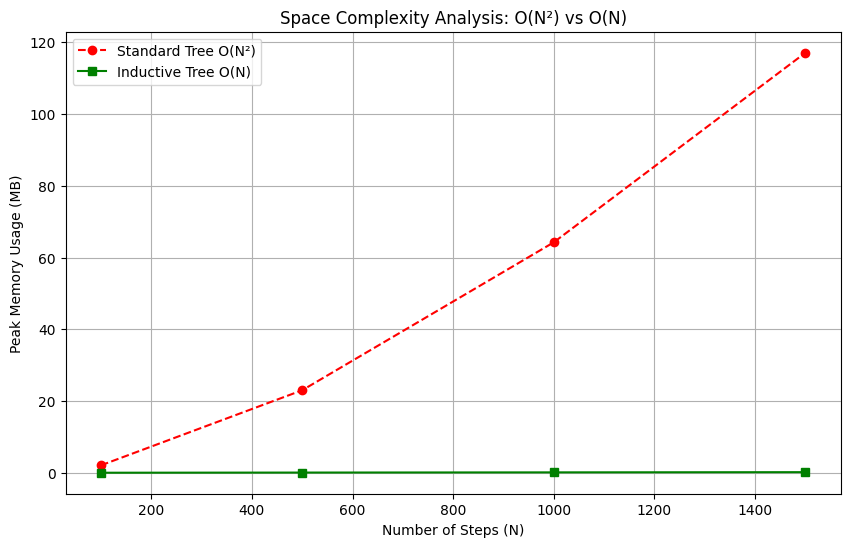

In [5]:
print(f"Trinomial Tree Pricing Time: {end_time - start_time:.6f} seconds")
print(
    f"Trinomial Tree Memory Usage: Current={current / 10**6:.6f}MB, Peak={peak / 10**6:.6f}MB"
)

def benchmark_memory(n, use_inductive, market_data, option):
    tree_cls = InductiveTree if use_inductive else Tree
    tracemalloc.start()
    tree_cls(num_steps=n, market_data=market_data, option=option).price()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak / 10**6

N_range = [100, 500, 1000, 1500]

print("Running Memory Scaling Benchmark (Parallelized)...")
results = {}

with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = {}
    for n in N_range:
        futures[executor.submit(benchmark_memory, n, False, market_data, european_call)] = ("Standard", n)
        futures[executor.submit(benchmark_memory, n, True, market_data, european_call)] = ("Inductive", n)
    
    for future in concurrent.futures.as_completed(futures):
        tree_type, n = futures[future]
        try:
            peak_mem = future.result()
            results[(tree_type, n)] = peak_mem
            print(f"  Finished {tree_type} Tree N={n} -> {peak_mem:.2f} MB")
        except Exception as e:
            print(f"  Error in {tree_type} Tree N={n}: {e}")
            results[(tree_type, n)] = float('nan')

mem_classic = [results.get(("Standard", n), 0) for n in N_range]
mem_inductive = [results.get(("Inductive", n), 0) for n in N_range]

plt.figure(figsize=(10, 6))
plt.plot(N_range, mem_classic, "o--", label="Standard Tree O(N²)", color="red")
plt.plot(N_range, mem_inductive, "s-", label="Inductive Tree O(N)", color="green")
plt.xlabel("Number of Steps (N)")
plt.ylabel("Peak Memory Usage (MB)")
plt.title("Space Complexity Analysis: O(N²) vs O(N)")
plt.legend()
plt.grid(True)
plt.show()

## 3. Financial Consistency (Put-Call Parity)

A robust pricer must respect fundamental no-arbitrage relations. For European options, **Put-Call Parity** must hold:
$$ C - P = S_0 - K e^{-rT} $$

We sweep across different Spot Prices ($S_0$) to verify that the residual error is negligible.

In [6]:
# Define a range of spot prices
S0_range = list(range(50, 151, 10))

# Run the experiment
parity_exp = PutCallParityExperiment(
    sweep_param="S0",
    param_values=S0_range,
    market_data=market_data,
    base_option=european_call, # Will automatically check Call vs Put
    fixed_N=200
)
parity_results = parity_exp.run()

# Display results table
parity_df = pd.DataFrame(parity_results)
print("Put-Call Parity Residuals (Mean Error):", parity_df['Residual'].abs().mean())
parity_df[['S0', 'Call_Price', 'Put_Price', 'Parity_Target', 'Residual']].head()

Put-Call Parity Residuals (Mean Error): 7.506283037563642e-08


,S0,Call_Price,Put_Price,Parity_Target,Residual
3,50,0.0000,49.8631,-49.8631,-0.0000
2,60,0.0000,39.8631,-39.8631,-0.0000
1,70,0.0000,29.8631,-29.8631,-0.0000
0,80,0.0000,19.8631,-19.8631,-0.0000
4,90,0.0007,9.8638,-9.8631,-0.0000


## Analysis Experiments
The following sections implement various analysis experiments (c.f. src/analysis/experiments/).

## 4. Convergence Analysis

We verify that the inductive Trinomial Tree price converges to the Black-Scholes price as the number of time steps $N$ increases.
*   **Price vs N**: Should oscillate around the BS price.
*   **Error vs N**: Should decrease linearly on a log-log scale (order of convergence).

In [7]:
N_values = [10, 20, 40, 80, 160, 320, 640]
conv_exp = ConvergenceExperiment(N_values, market_data, european_call)
conv_results = conv_exp.run()

# Plot Price Convergence
Visualizer.plot_convergence_price(conv_results).show()

# Plot Error Convergence
Visualizer.plot_convergence_error(conv_results).show()

Experiment Convergence Analysis failed for N=10: Number of steps must be greater than 10 for accuracy.


## 5. Sensitivity Analysis (Greeks)

We analyze how the option price and its derivatives (Greeks) behave with respect to the underlying Spot Price ($S_0$).

*   **Delta**: First derivative $\partial V / \partial S$.
*   **Gamma**: Second derivative $\partial^2 V / \partial S^2$.

**Note on Gamma Calculation:**
We compare two methods:
1.  **Finite Difference (FD)**: Calculated by bumping the initial spot price $S_0 \pm \epsilon$. This often results in "saw-tooth" noise due to the discrete nature of the tree grid shifting relative to the strike.
2.  **Internal Tree Gamma**: Calculated directly from the tree's nodes at the first time step ($t=1$). This method is numerically stable and represents the true curvature of the tree model without grid-shifting artifacts.

In [8]:
# Sweep Spot Price from 50 to 150
S0_values = [float(x) for x in range(50, 151, 2)]

spot_exp = SpotSensitivityExperiment(S0_values, market_data, european_call, N=1000)
spot_results = spot_exp.run()

# Plot Price vs Spot
Visualizer.plot_price_vs_spot(spot_results).show()

# Plot Delta vs Spot
Visualizer.plot_greeks_vs_spot(spot_results, "Delta").show()

# Plot Gamma vs Spot (Comparing FD and Internal)
Visualizer.plot_greeks_vs_spot(spot_results, "Gamma").show()

## 5.2 Volatility Sensitivity (Vega Profiling)

We compare the Tree's response to the Black-Scholes analytical benchmark across a wide range of volatilities ($\sigma \in [5\%, 100\%]$).

In [9]:
vol_range = [v/100.0 for v in range(5, 101, 5)]

vol_exp = VolatilitySensitivityExperiment(
    vol_values=vol_range,
    market_data=market_data,
    option=european_call, 
    N=100
)
vol_results = vol_exp.run()
vol_df = pd.DataFrame(vol_results)

# Plot Price vs Volatility
fig = go.Figure()
fig.add_trace(go.Scatter(x=vol_df["Volatility"], y=vol_df["Tree_Price"], mode='markers', name='Tree Price'))
fig.add_trace(go.Scatter(x=vol_df["Volatility"], y=vol_df["BS_Price"], mode='lines', name='Black-Scholes (Analytical)'))
fig.update_layout(title="Option Price Sensitivity to Volatility", xaxis_title="Volatility (sigma)", yaxis_title="Option Price")
fig.show()

# Plot Error
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=vol_df["Volatility"], y=vol_df["Error"], mode='lines+markers', name='Absolute Error'))
fig2.update_layout(title="Pricing Error vs Volatility", xaxis_title="Volatility (sigma)", yaxis_title="Abs Error")
fig2.show()

## 5.3 Empirical Greeks Validation

Finally, we validate the "Greeks" (sensitivities) calculated by the tree by comparing them to:
1.  **Black-Scholes Analytical Greeks** (Ground Truth).
2.  **Empirical Shocks**: Manually bumping inputs ($S_0 + \epsilon$) and re-pricing.

This confirms that the `InductiveTree` correctly captures risk metrics.

In [10]:
# Use EmpiricalGreeks to shock the tree parameters
greek_engine = EmpiricalGreeks(
    tree=InductiveTree(num_steps=200, market_data=market_data, option=european_call)
)

# 1. Delta (dS)
tree_delta = greek_engine.approximate_delta()
bs_pricer = BlackScholes(market_data, european_call)
bs_delta = bs_pricer.delta()

# 2. Gamma (dS^2)
tree_gamma = greek_engine.approximate_gamma()
bs_gamma = bs_pricer.gamma()

# 3. Vega (dSigma)
tree_vega = greek_engine.approximate_vega()
bs_vega = bs_pricer.vega()

# 4. Theta (dt)
tree_theta = greek_engine.approximate_theta()
bs_theta = bs_pricer.theta()

# Compare Results
greeks_df = pd.DataFrame({
    "Greek": ["Delta", "Gamma", "Vega", "Theta"],
    "Tree (Empirical)": [tree_delta, tree_gamma, tree_vega, tree_theta],
    "Black-Scholes": [bs_delta, bs_gamma, bs_vega, bs_theta]
})
greeks_df["Diff %"] = 100 * (greeks_df["Tree (Empirical)"] - greeks_df["Black-Scholes"]).abs() / greeks_df["Black-Scholes"].abs()

print("Greeks Validation (N=200):")
print(greeks_df)

Greeks Validation (N=200):
   Greek  Tree (Empirical)  Black-Scholes  Diff %
0  Delta            0.5228         0.5231  0.0617
1  Gamma            0.1178         0.1203  2.0548
2   Vega            0.0659         0.0659  0.0399
3  Theta           -0.0747        -0.0729  2.5009


## 6. Structural Analysis: American Options

One of the main advantages of Tree methods is handling American options. Here we visualize the **Early Exercise Boundary** for an American Put.
*   **Exercise Region**: Where Intrinsic Value > Continuation Value.
*   **Boundary**: The critical spot price $S^*(t)$ below which it is optimal to exercise immediately.

In [11]:
# Define American Put
american_put = Option(
    maturity=maturity,
    strike_price=100.0,
    is_call=False,
    is_american=True, # Enable Early Exercise
    barrier=None,
    pricing_date=today,
    calendar_base_convention=365
)

# Run Boundary Analysis
boundary_exp = ExerciseBoundaryExperiment(market_data, american_put, N=200)
boundary_results = boundary_exp.run()

Visualizer.plot_exercise_boundary(boundary_results).show()

### 6.2 Terminal Distribution

Finally, we inspect the probability distribution of the underlying asset at maturity implied by the Tree.
*   It should approximate a **Lognormal Distribution**.
*   We overlay the theoretical PDF to validate the tree's diffusion process.

In [12]:
dist_exp = TerminalDistributionExperiment(market_data, european_call, N=50)
dist_results = dist_exp.run()

Visualizer.plot_terminal_distribution(dist_results).show()